In [ ]:

import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import io
import sys



In [3]:

dfs = {}

if os.path.exists('stats.txt'):
    os.remove('stats.txt')

with open('stats.txt', 'w') as log_file:
    for file in os.listdir():

        if file.endswith('.csv'):
            df = pd.read_csv(file)
            dfs[file] = df

            # Write file name as header
            log_file.write(f"======= {file} =======\n\n")
            
            # Write head()
            log_file.write("1. HEAD:\n")
            log_file.write(df.head().to_string())
            log_file.write("\n\n")
            
            # Write describe()
            log_file.write("2. DESCRIBE:\n")
            log_file.write(df.describe().to_string())
            log_file.write("\n\n")
            
            # Write info() has to use StringIO as it prints to stdout
            log_file.write("3. INFO checking types:\n")
            buffer = io.StringIO()
            df.info(buf=buffer)
            log_file.write(buffer.getvalue())
            log_file.write("\n\n")
            
            # Write missing values
            log_file.write("4. MISSING VALUES:\n")
            log_file.write(df.isnull().sum().to_string())
            log_file.write("\n\n")

            
            log_file.write("\n\n" + "="*60 + "\n\n")

print("Statistics written to stats.txt")

Statistics written to stats.txt


By analysing the stats.txt, data is clean and consistent.   
4935 rows of app_version missing in session.csv, 38224 rows of region missing in users.csv. See if we could retrieve these missing values by matching with user_id or its just not important.   
final_stage = < not important for our project> 



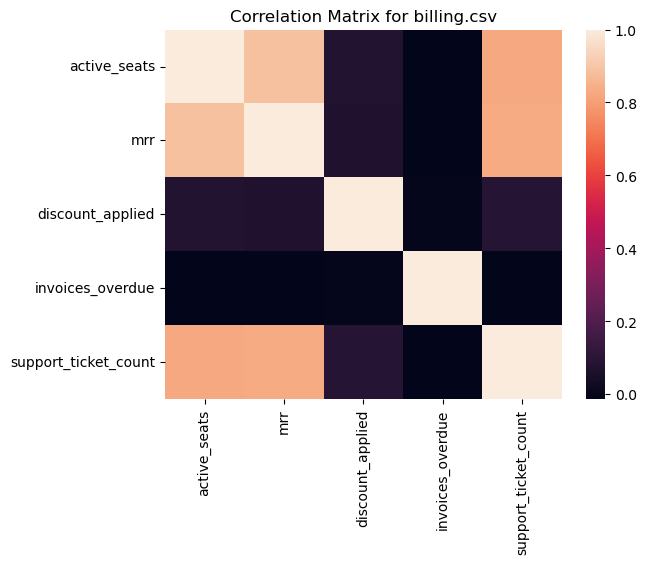

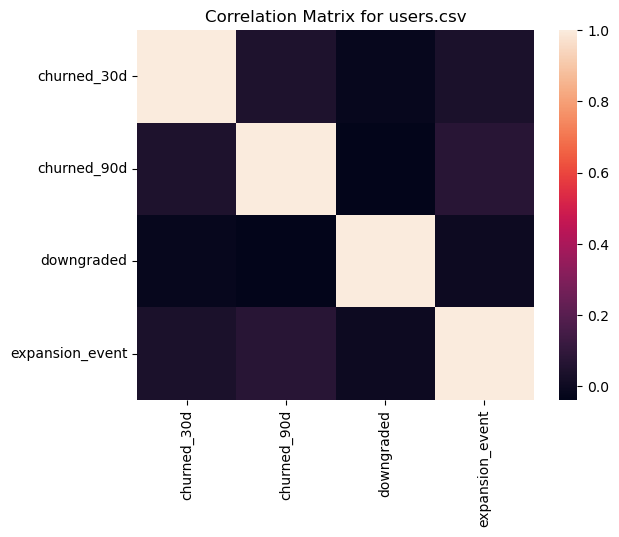

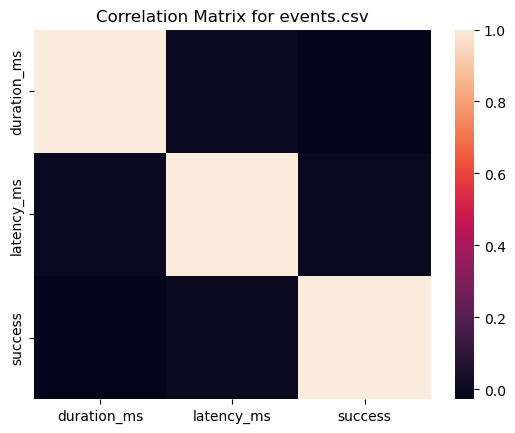

'sessions.csv' has only one numeric column, so no correlation matrix can be generated.


In [4]:
# correlation heatmaps for each dataframe

for filename, df in dfs.items():
    
    numeric_cols = df.select_dtypes(include=['number'])
    
    # Ensure there is more than one numeric column to create a matrix
    if not numeric_cols.empty and len(numeric_cols.columns) > 1:
        sns.heatmap(numeric_cols.corr())
        plt.title(f'Correlation Matrix for {filename}')
        plt.show()
    elif len(numeric_cols.columns) == 1:
        print(f"'{filename}' has only one numeric column, so no correlation matrix can be generated.")
    else:
        print(f"'{filename}' has no numeric columns to plot a correlation matrix.")

billing.csv: mrr, active _seats, support_ticket_count are correlated (see them as one group).

In [8]:
users_df = dfs['users.csv'].drop_duplicates(subset=['user_id'])

# find the count of churn30, churn90
users_df['churned_30d'].value_counts(), users_df['churned_90d'].value_counts()

(churned_30d
 0    87039
 1    12961
 Name: count, dtype: int64,
 churned_90d
 0    77008
 1    22992
 Name: count, dtype: int64)

In [9]:
user_churn_030 = users_df[users_df['churned_30d'] == 1]
user_churn_090 = users_df[users_df['churned_90d'] == 1]
user_churn_3090 = users_df[(users_df['churned_30d'] == 0) & (users_df['churned_90d'] == 1)]

user_churn_030.groupby('plan_tier').size()

plan_tier
free        9064
premium      891
standard    3006
dtype: int64

/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_93348/3913301201.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = plot_df.groupby('churned_90d').apply(


Text(0.5, 1.02, 'Pairplot of User Behaviors, Colored by 90-Day Churn')

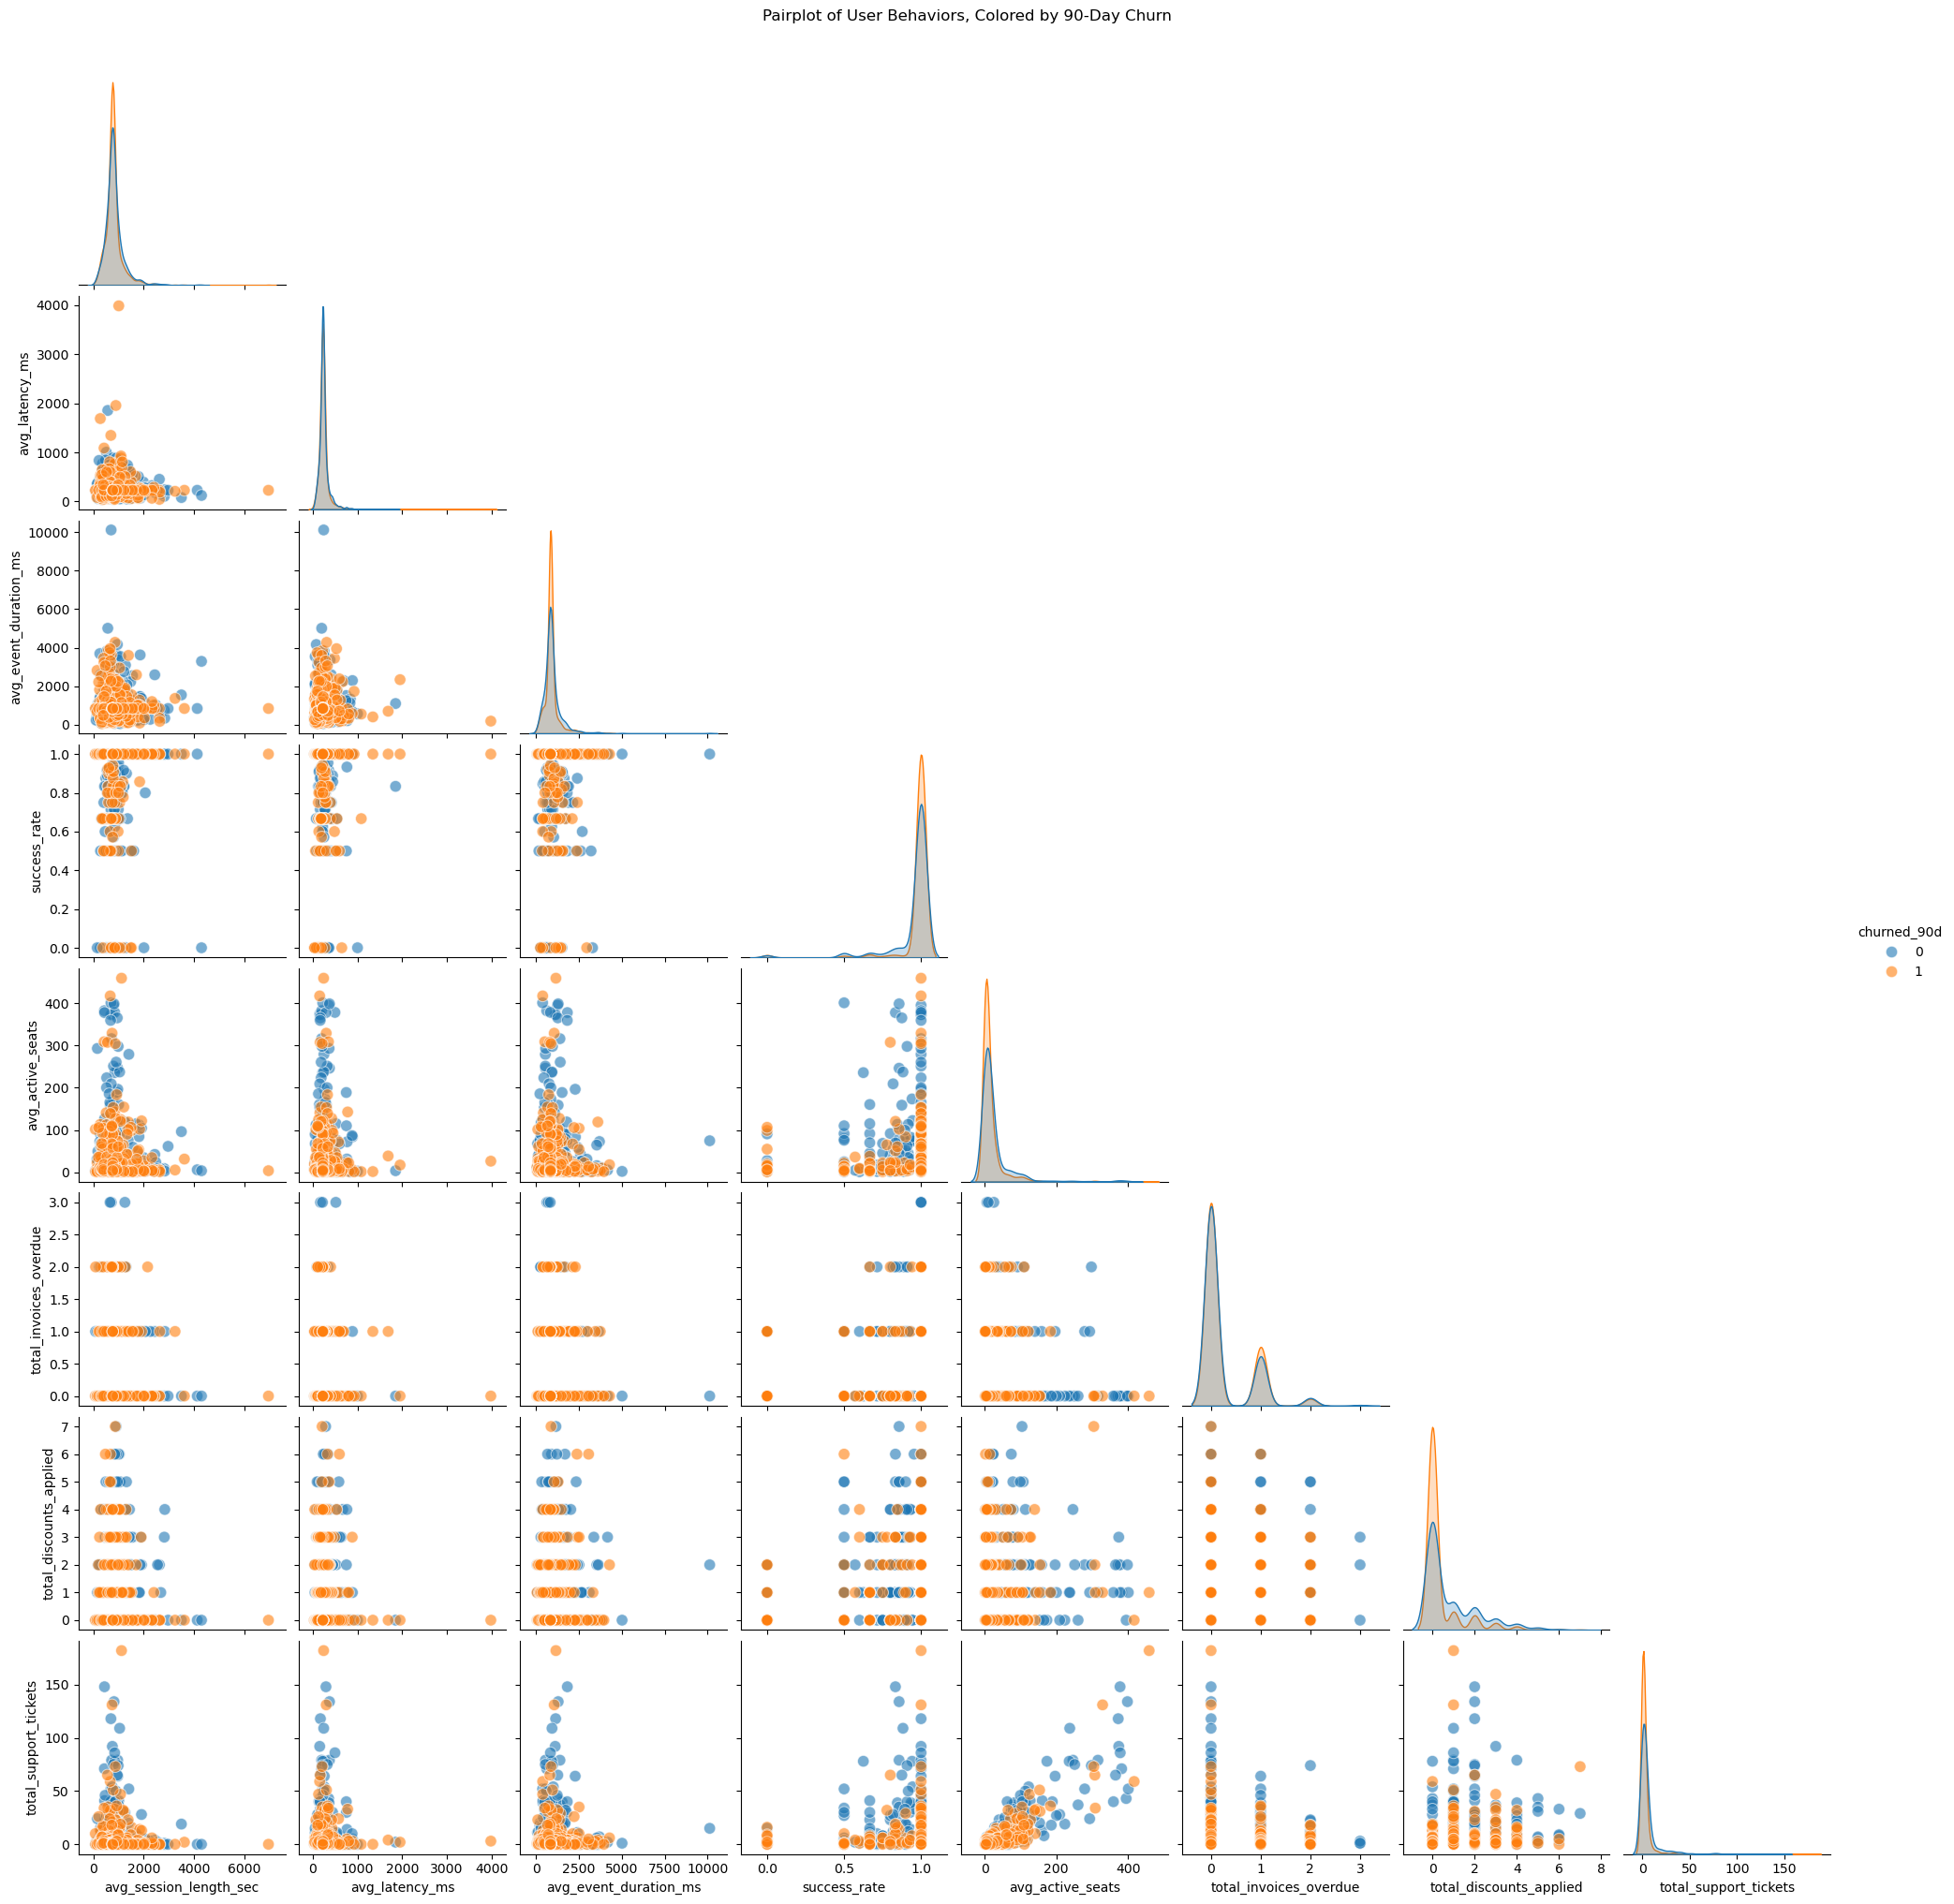

In [12]:
billing_df = dfs['billing.csv']
sessions_df = dfs['sessions.csv']
events_df = dfs['events.csv']

# a) Billing data aggregation
billing_agg = billing_df.groupby('user_id').agg(
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

# b) Event data aggregation
events_agg = events_df.groupby('user_id').agg(
    avg_latency_ms=('latency_ms', 'mean'),
    avg_event_duration_ms=('duration_ms', 'mean'),
    success_rate=('success', lambda x: x.sum() / x.count() if x.count() > 0 else 0)
).reset_index()

# c) Session data aggregation
sessions_agg = sessions_df.groupby('user_id').agg(
    avg_session_length_sec=('session_length_sec', 'mean'),
    total_sessions=('session_id', 'count')
).reset_index()

# merge
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, events_agg, on='user_id', how='left')

# 'upgraded' defined as 'expansion_event'
df.rename(columns={'expansion_event': 'upgraded'}, inplace=True)

numerical_vars = [
    'avg_session_length_sec', 'avg_latency_ms', 'avg_event_duration_ms',
    'success_rate', 'avg_active_seats', 'total_invoices_overdue',
    'total_discounts_applied', 'total_support_tickets'
]

target_vars = ['churned_30d', 'churned_90d', 'downgraded', 'upgraded']

plot_df = df[numerical_vars + target_vars].copy()
plot_df.fillna(plot_df.median(), inplace=True)

# Sample the data for pairplot
sample_df = plot_df.groupby('churned_90d').apply(
    lambda x: x.sample(n=min(len(x), 1000), random_state=22)
).reset_index(drop=True)

g = sns.pairplot(
    sample_df,
    vars=numerical_vars, 
    hue='churned_90d',    
    diag_kind='kde',      
    plot_kws={'alpha': 0.6, 's': 80}, 
    corner=True      
)

g.fig.suptitle("Pairplot of User Behaviors, Colored by 90-Day Churn", y=1.02)

/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_93348/3671493667.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = plot_df.groupby('churned_90d').apply(


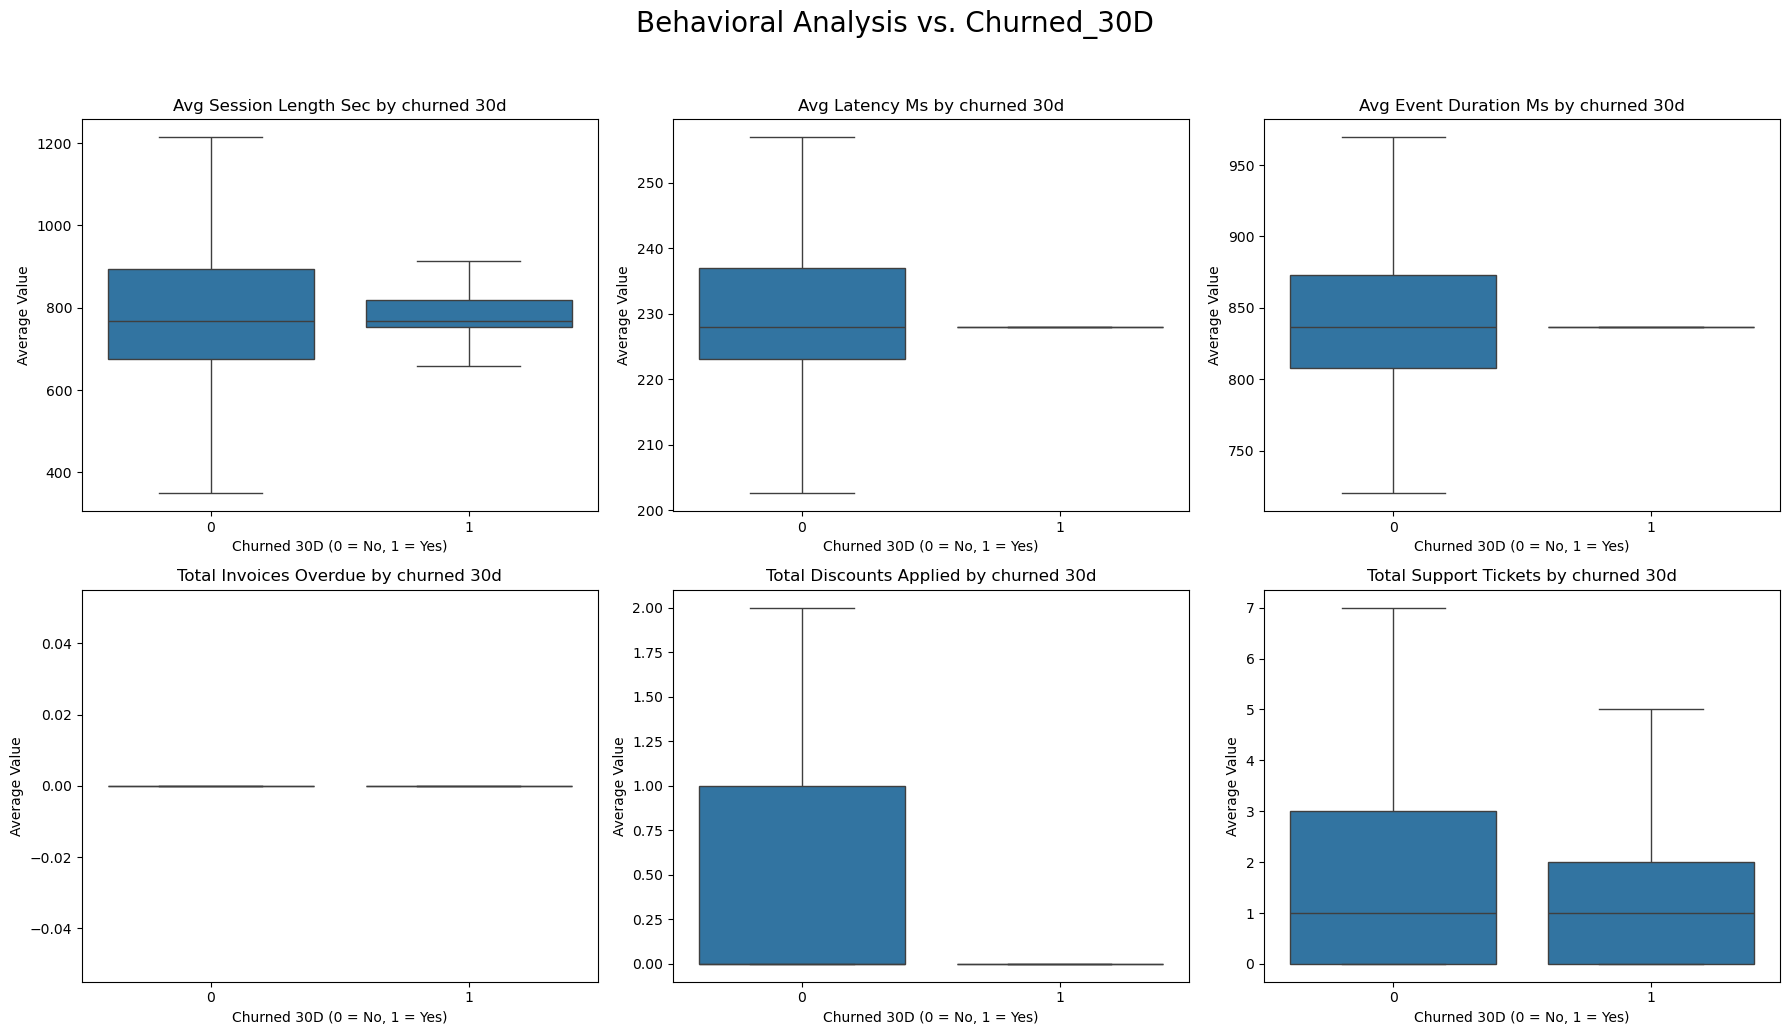

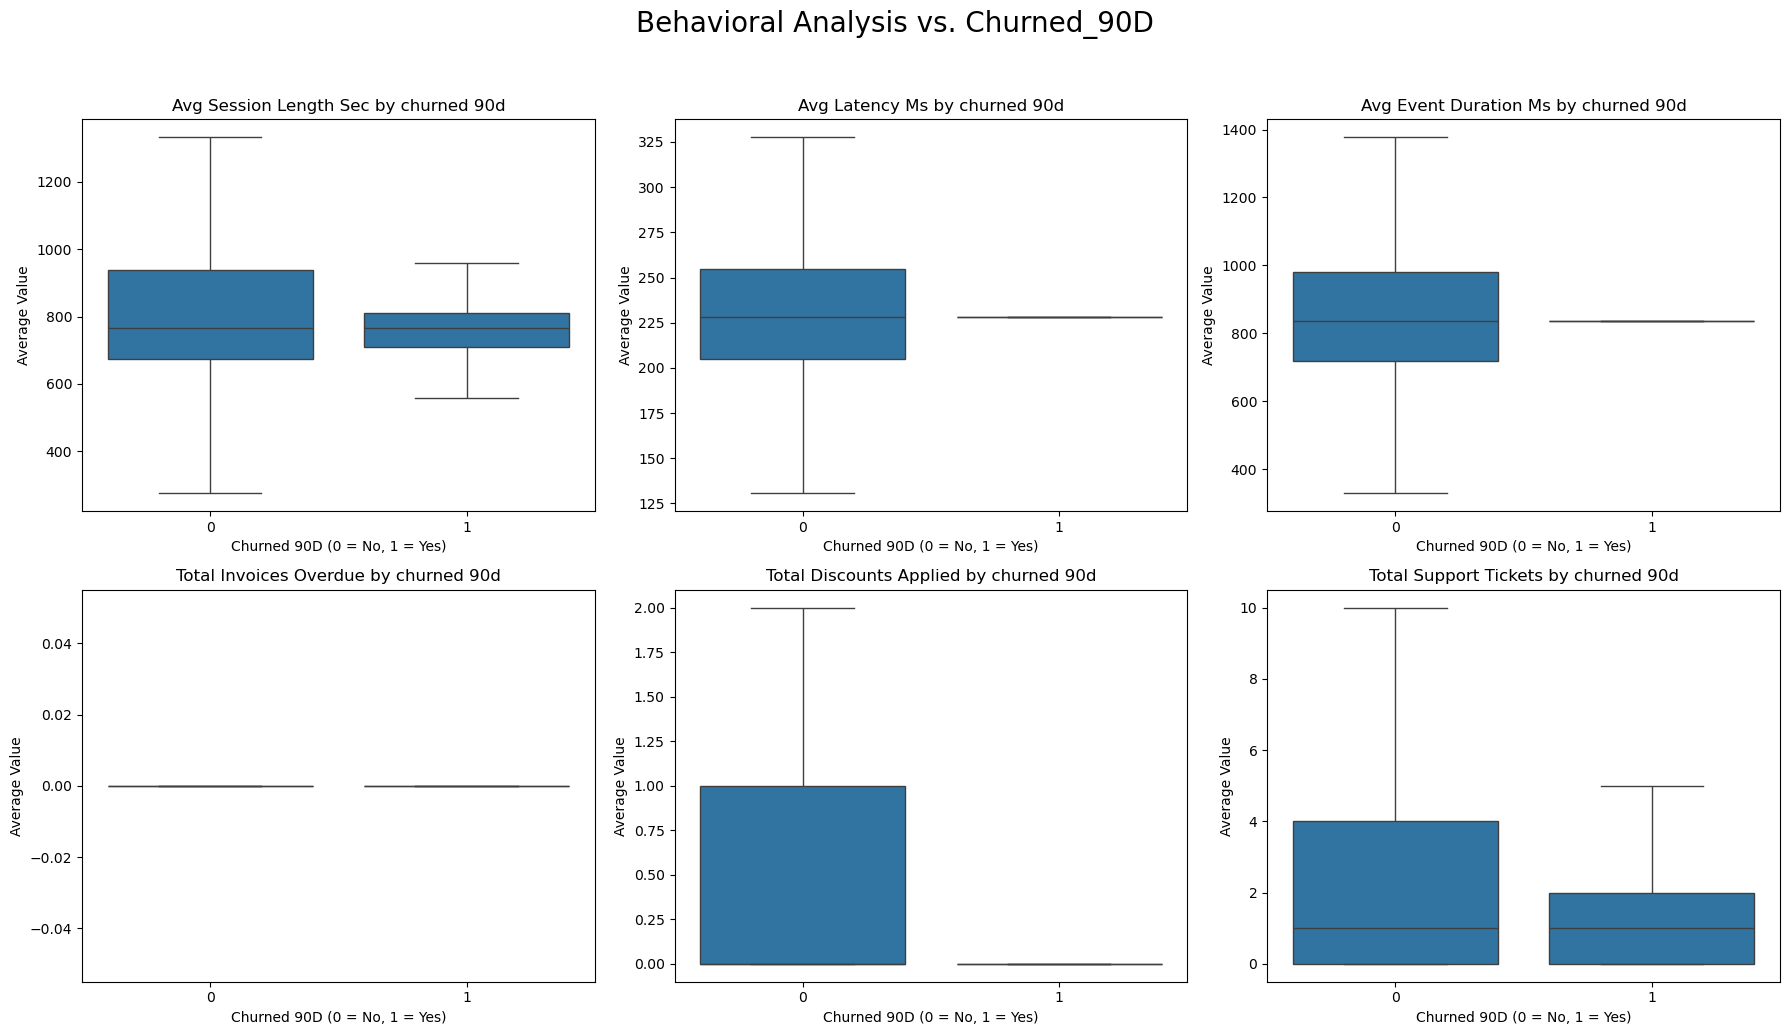

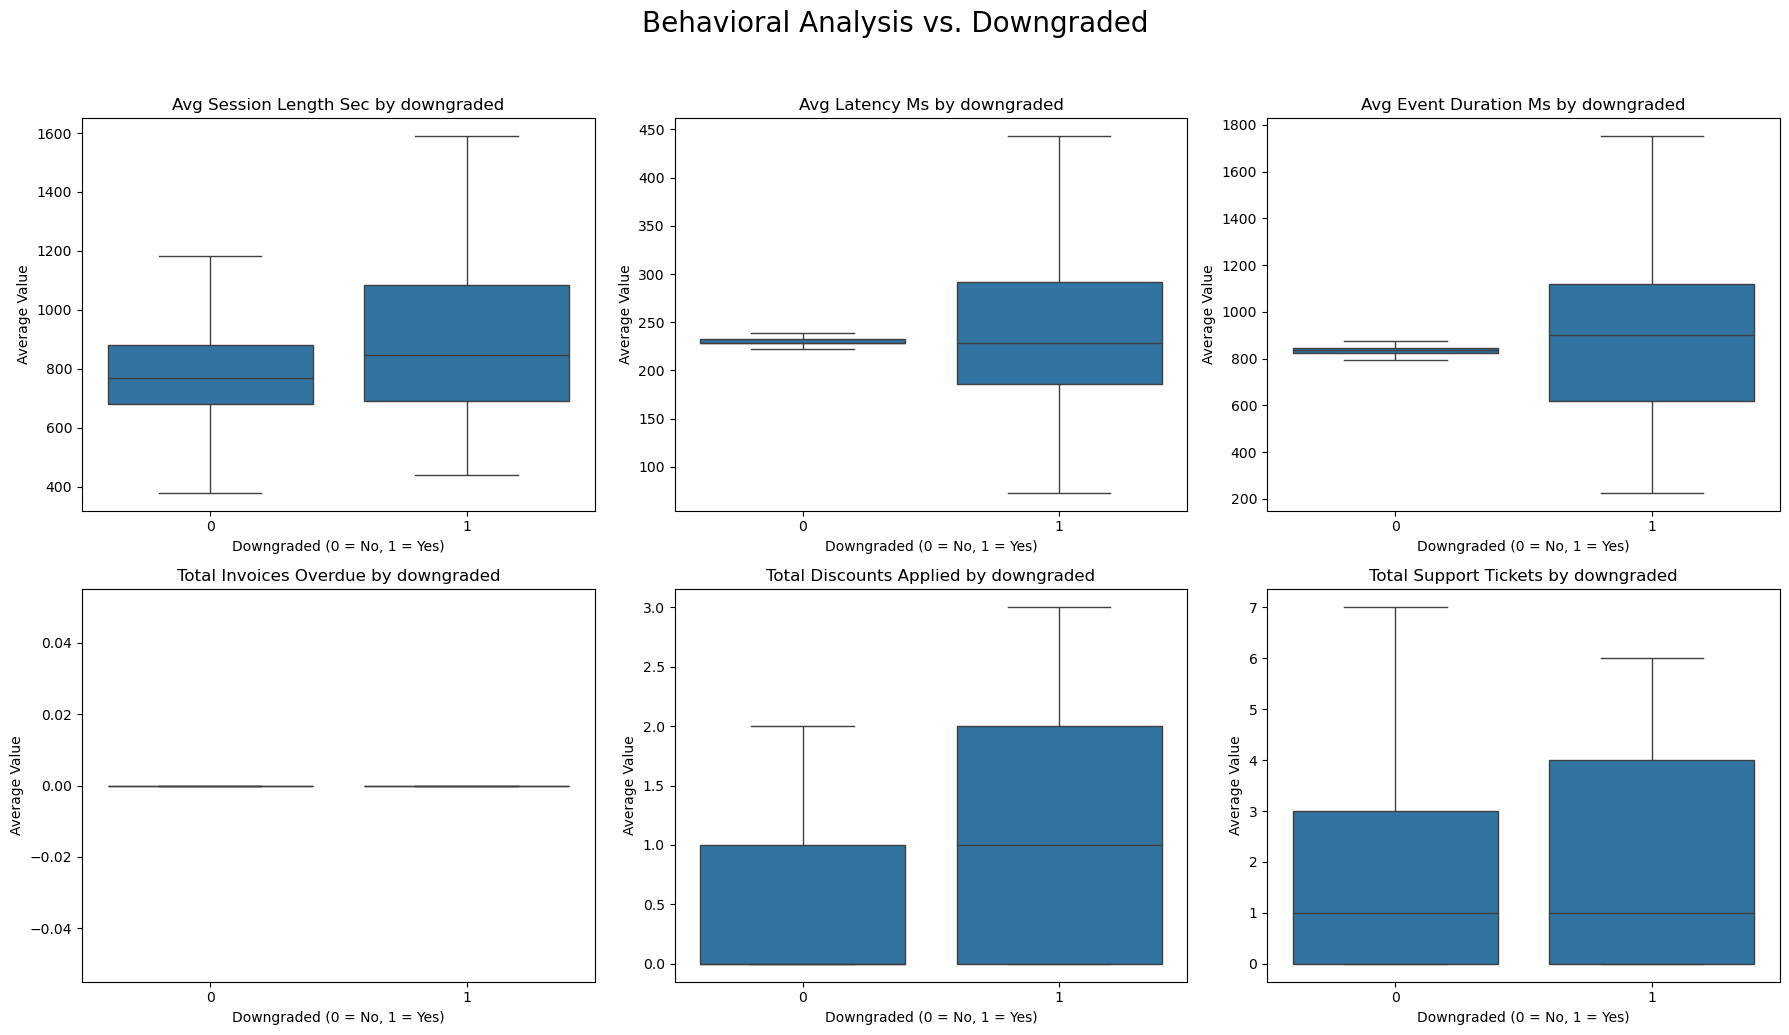

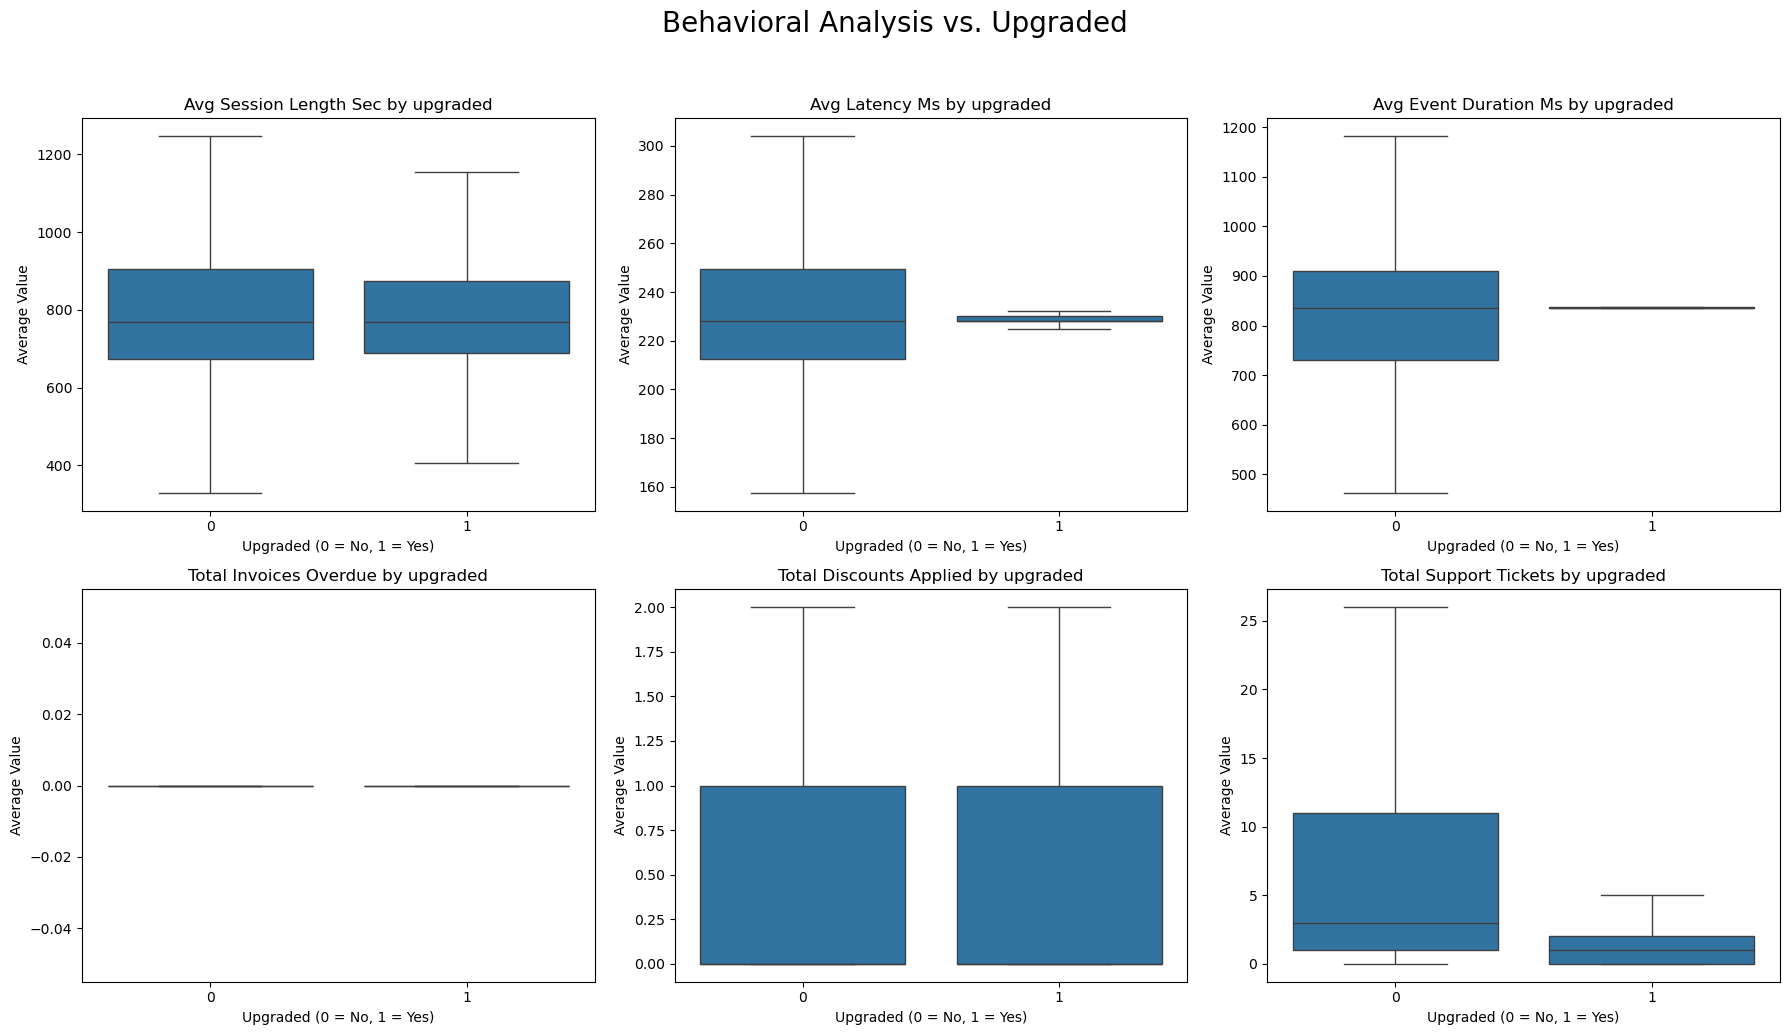

In [14]:
# Updated list of X variables, removing 'avg_active_seats' and 'success_rate'
x_vars = [
    'avg_session_length_sec', 'avg_latency_ms', 'avg_event_duration_ms',
    'total_invoices_overdue', 'total_discounts_applied', 'total_support_tickets'
]

y_vars = ['churned_30d', 'churned_90d', 'downgraded', 'upgraded']

plot_df = df[x_vars + y_vars].copy()
for col in x_vars:
    plot_df[col] = plot_df[col].fillna(plot_df[col].median())

# Sample the data again
sample_df = plot_df.groupby('churned_90d').apply(
    lambda x: x.sample(n=min(len(x), 1000), random_state=42)
).reset_index(drop=True)


for y_var in y_vars:
    n_cols = 3
    n_rows = (len(x_vars) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    fig.suptitle(f'Behavioral Analysis vs. {y_var.title()}', fontsize=20, y=1.03)

    axes = axes.flatten()

    for i, x_var in enumerate(x_vars):
        sns.boxplot(x=y_var, y=x_var, data=sample_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{x_var.replace("_", " ").title()} by {y_var.replace("_", " ")}')
        axes[i].set_xlabel(f'{y_var.replace("_", " ").title()} (0 = No, 1 = Yes)')
        axes[i].set_ylabel('Average Value')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()

Generating combined visualization...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_93348/1027057931.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_features_per_plan = feature_counts.groupby('plan_tier').apply(


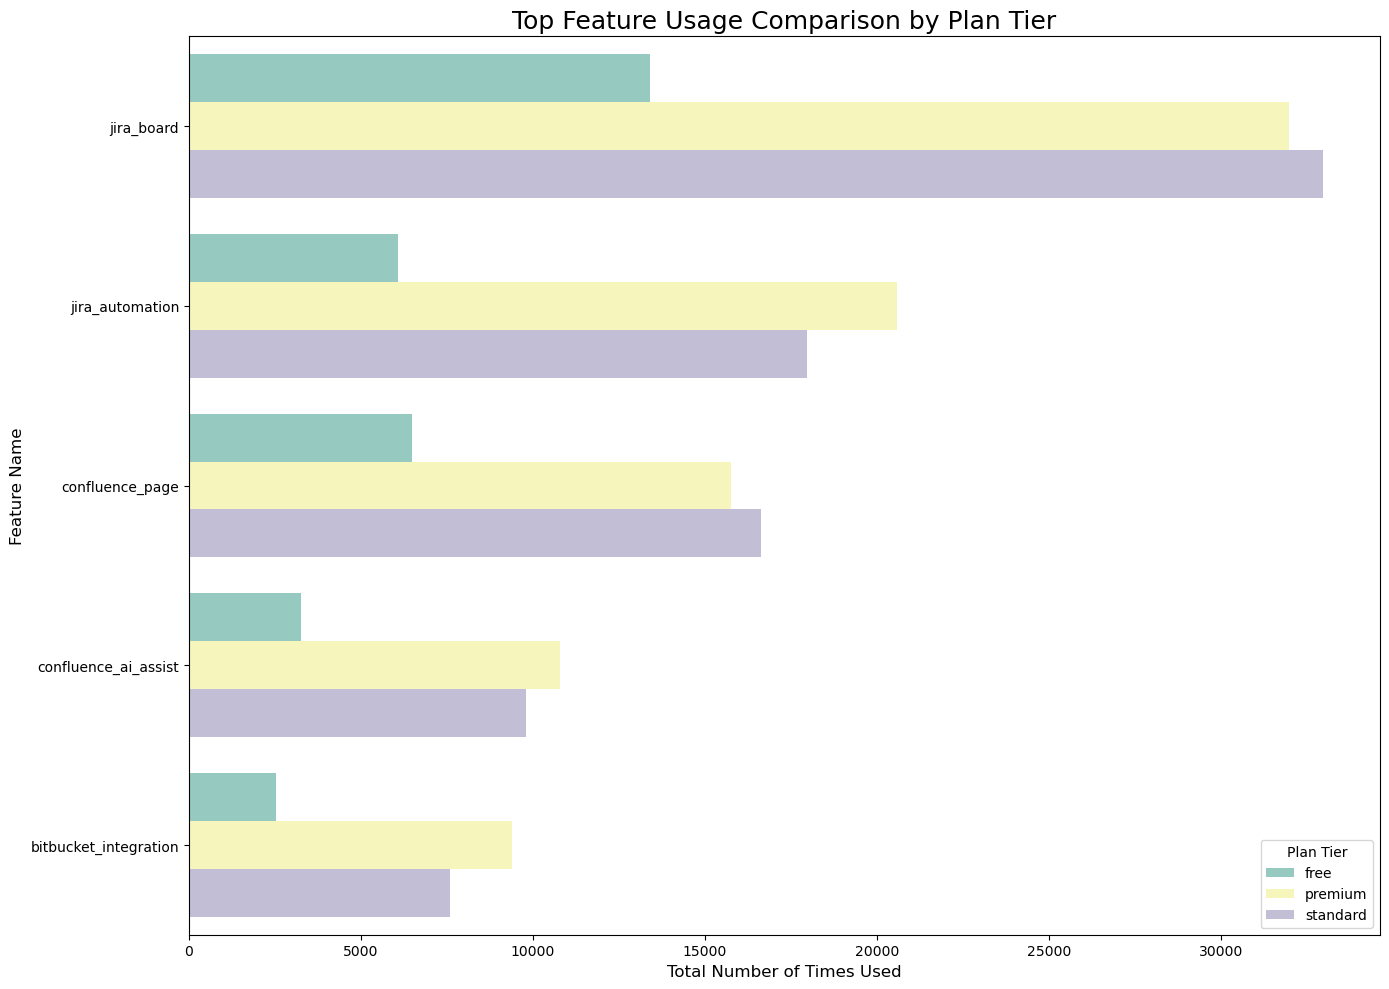

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


user_plan_df = users_df[['user_id', 'plan_tier']].drop_duplicates(subset='user_id')
merged_df = pd.merge(events_df, user_plan_df, on='user_id', how='left')
merged_df.dropna(subset=['plan_tier'], inplace=True)


feature_counts = merged_df.groupby(['plan_tier', 'feature_name']).size().reset_index(name='usage_count')

top_features_per_plan = feature_counts.groupby('plan_tier').apply(
    lambda x: x.nlargest(5, 'usage_count')
).reset_index(drop=True)

all_top_features = top_features_per_plan['feature_name'].unique()
plot_data = feature_counts[feature_counts['feature_name'].isin(all_top_features)]


print("Generating combined visualization...")
plt.figure(figsize=(14, 10))
sns.barplot(
    data=plot_data,
    x='usage_count',
    y='feature_name',
    hue='plan_tier',
    palette='Set3',
    order=plot_data.groupby('feature_name')['usage_count'].sum().sort_values(ascending=False).index # Order by total usage
)

plt.title('Top Feature Usage Comparison by Plan Tier', fontsize=18)
plt.xlabel('Total Number of Times Used', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.legend(title='Plan Tier')
plt.tight_layout()

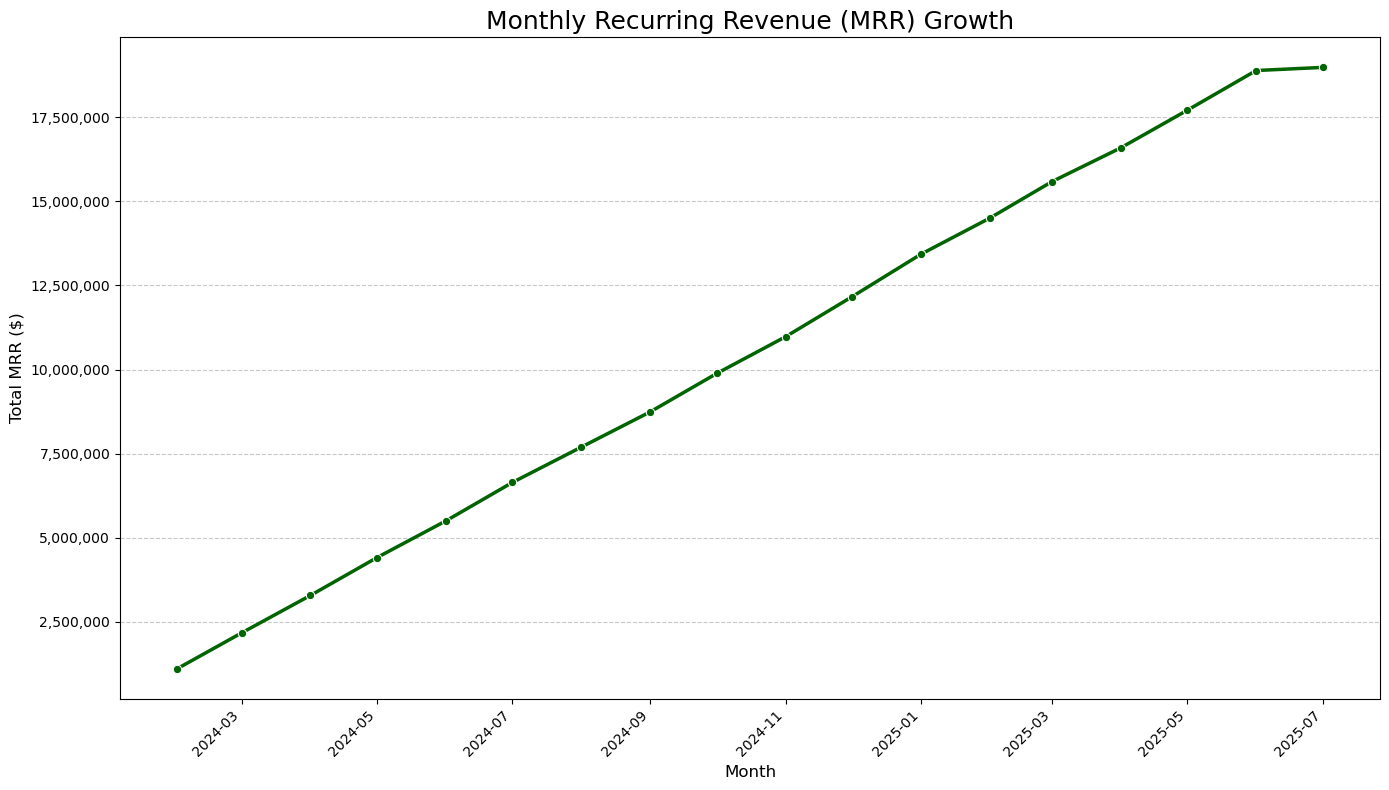

In [22]:
billing_df['month'] = pd.to_datetime(billing_df['month'])
monthly_mrr = billing_df.groupby('month')['mrr'].sum().reset_index()


plt.figure(figsize=(14, 8))
sns.lineplot(
    data=monthly_mrr,
    x='month',
    y='mrr',
    marker='o',
    color='darkgreen',
    linewidth=2.5
)

plt.title('Monthly Recurring Revenue (MRR) Growth', fontsize=18)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total MRR ($)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_93348/2465826136.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([d.strftime('%Y-%m') for d in monthly_signups['signup_month']])


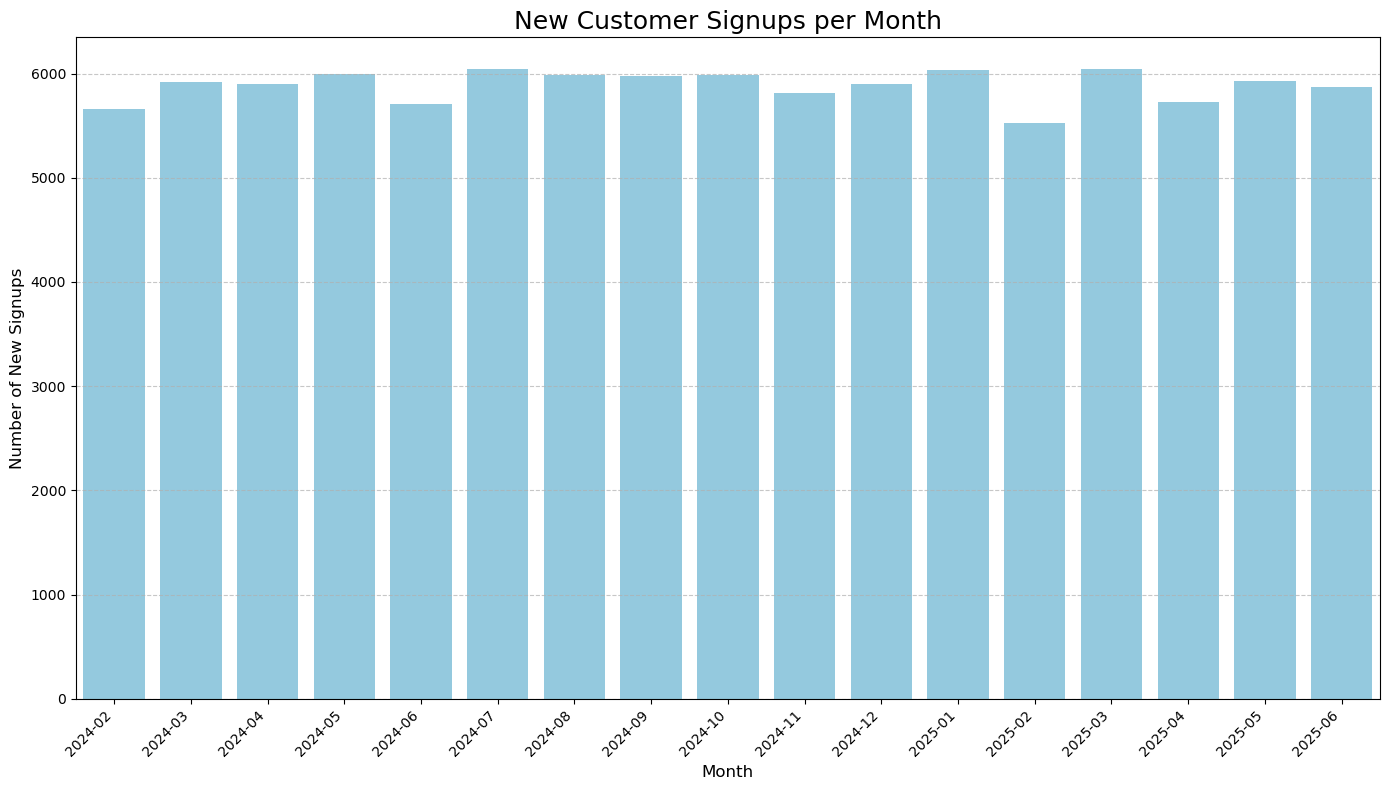

In [19]:
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
users_df['signup_month'] = users_df['signup_date'].dt.to_period('M').dt.to_timestamp()
monthly_signups = users_df.groupby('signup_month').size().reset_index(name='new_signups')


plt.figure(figsize=(14, 8))
sns.barplot(
    data=monthly_signups,
    x='signup_month',
    y='new_signups',
    color='skyblue'
)

plt.title('New Customer Signups per Month', fontsize=18)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of New Signups', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax = plt.gca()
ax.set_xticklabels([d.strftime('%Y-%m') for d in monthly_signups['signup_month']])

plt.xticks(rotation=45, ha='right')
plt.tight_layout()



--- Monthly Revenue Growth Summary ---
        month    new_mrr  expansion_mrr  churned_mrr  contraction_mrr  \
0  2024-03-01  1057027.6        45830.8          0.0          38967.6   
1  2024-04-01  1110485.6        93724.4          0.0          89885.4   
2  2024-05-01  1109736.8       141171.0          0.0         124922.2   
3  2024-06-01  1080997.8       190054.6          0.0         181138.8   
4  2024-07-01  1129295.6       231954.8          0.0         217612.0   
5  2024-08-01  1011873.2       291020.4          0.0         253424.2   
6  2024-09-01  1013583.4       332026.4          0.0         299144.6   
7  2024-10-01  1127248.6       370350.0          0.0         355144.0   
8  2024-11-01  1059697.4       431094.0          0.0         398556.2   
9  2024-12-01  1095420.0       504327.8          0.0         408641.2   
10 2025-01-01  1200363.0       526186.8          0.0         463389.8   
11 2025-02-01  1032144.6       567000.0          0.0         526677.4   
12 2025-03-

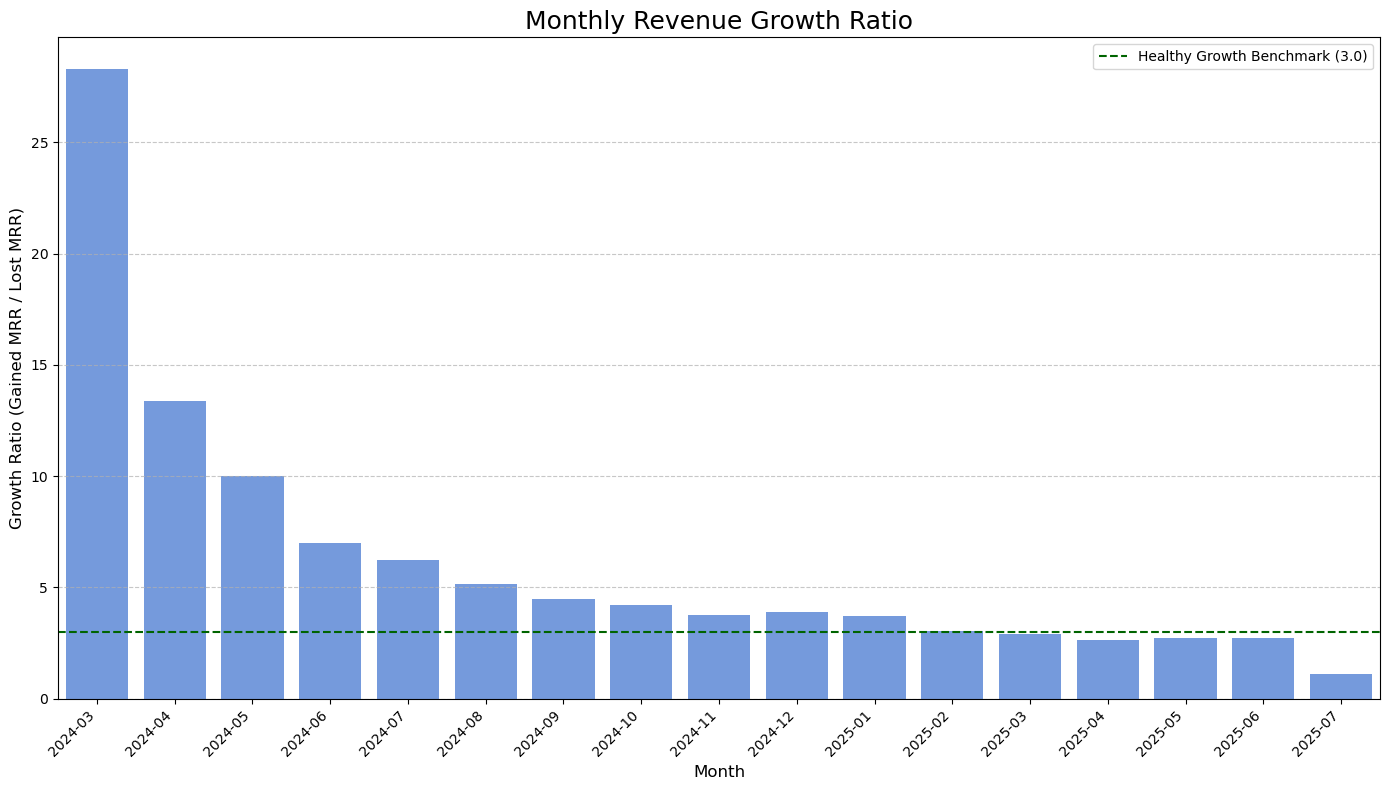

In [21]:

billing_df['month'] = pd.to_datetime(billing_df['month'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])

months = sorted(billing_df['month'].unique())
growth_data = []

for i in range(1, len(months)):
    current_month_date = months[i]
    previous_month_date = months[i-1]

    current_month_df = billing_df[billing_df['month'] == current_month_date]
    previous_month_df = billing_df[billing_df['month'] == previous_month_date]

    current_users = set(current_month_df['user_id'])
    previous_users = set(previous_month_df['user_id'])

    new_user_ids = current_users - previous_users
    new_mrr = current_month_df[current_month_df['user_id'].isin(new_user_ids)]['mrr'].sum()

    churned_user_ids = previous_users - current_users
    churned_mrr = previous_month_df[previous_month_df['user_id'].isin(churned_user_ids)]['mrr'].sum()

    retained_user_ids = current_users.intersection(previous_users)
    retained_df_current = current_month_df[current_month_df['user_id'].isin(retained_user_ids)].set_index('user_id')
    retained_df_previous = previous_month_df[previous_month_df['user_id'].isin(retained_user_ids)].set_index('user_id')
    
    mrr_diff = retained_df_current['mrr'] - retained_df_previous['mrr']
    
    expansion_mrr = mrr_diff[mrr_diff > 0].sum()
    contraction_mrr = -mrr_diff[mrr_diff < 0].sum() 

    revenue_gained = new_mrr + expansion_mrr
    revenue_lost = churned_mrr + contraction_mrr
    
    growth_ratio = revenue_gained / revenue_lost if revenue_lost > 0 else revenue_gained

    growth_data.append({
        'month': current_month_date,
        'new_mrr': new_mrr,
        'expansion_mrr': expansion_mrr,
        'churned_mrr': churned_mrr,
        'contraction_mrr': contraction_mrr,
        'growth_ratio': growth_ratio
    })

monthly_growth_df = pd.DataFrame(growth_data)

print("\n--- Monthly Revenue Growth Summary ---")
print(monthly_growth_df.round(2))

print("\nGenerating revenue growth ratio chart...")
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=monthly_growth_df,
    x=monthly_growth_df['month'].dt.strftime('%Y-%m'),
    y='growth_ratio',
    color='cornflowerblue'
)

ax.axhline(3, color='darkgreen', linestyle='--', label='Healthy Growth Benchmark (3.0)')

plt.title('Monthly Revenue Growth Ratio', fontsize=18)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Growth Ratio (Gained MRR / Lost MRR)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('revenue_growth_ratio.png')
print("\nRevenue growth ratio chart saved as 'revenue_growth_ratio.png'")